<a href="https://colab.research.google.com/github/guscldns/TestProject/blob/main/0615/0615_03_Seq2Seq_%E1%84%80%E1%85%B5%E1%84%80%E1%85%A8%E1%84%87%E1%85%A5%E1%86%AB%E1%84%8B%E1%85%A7%E1%86%A8_%ED%94%84%EC%98%81(%E1%84%89%E1%85%AE%E1%84%8B%E1%85%A5%E1%86%B8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

## Download the data


In [34]:
!wget http://www.manythings.org/anki/fra-eng.zip

--2023-06-15 01:40:05--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7420323 (7.1M) [application/zip]
Saving to: ‘fra-eng.zip.1’

fra-eng.zip.1       100%[===================>]   7.08M  34.9MB/s    in 0.2s    

2023-06-15 01:40:06 (34.9 MB/s) - ‘fra-eng.zip.1’ saved [7420323/7420323]



In [40]:
zipfilename = '/content/fra-eng.zip'

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall('.')

# fra.txt 파일 저장됨

In [ ]:
# @title 코드 안됨
# http = urllib3.PoolManager()
# url ='http://www.manythings.org/anki/fra-eng.zip'
# filename = 'fra-eng.zip'
# path = os.getcwd()
# zipfilename = os.path.join(path, filename)

# with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:
#     shutil.copyfileobj(r, out_file)

# with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
#     zip_ref.extractall(path)

## Configuration


In [41]:
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 100  # Number of epochs to train for.
HIDDEN_DIM = 256  # Latent dimensionality of the encoding space.
EMBEDDING_DIM = 64
NUM_SAMPLES = 33000  # Number of samples to train on.

## Prepare the data


데이터셋을 다운로드한 후에 데이터를 준비하고자 다음의 단계를 수행합니다.

1. 각 문장에 start와 end 토큰을 추가합니다.
2. 특정 문자를 제거함으로써 문장을 정리합니다.
3. 단어 인덱스와 아이디(ID) 인덱스를 생성합니다. (단어 → 아이디(ID), 아이디(ID) → 단어로 매핑된 딕셔너리).
4. 각 문장을 입력층의 최대 길이만큼 패딩(padding)을 수행합니다.

In [42]:
def unicode_to_ascii(s): # 프랑스어에만 있는 전처리
  # 프랑스어 악센트(accent) 삭제
  # 예시 : 'déjà diné' -> deja dine
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [43]:
def preprocess_sentence(sent):
  # 악센트 삭제 함수 호출
  sent = unicode_to_ascii(sent.lower()) # 악센트 제거

  # 단어와 구두점 사이에 공백을 만듭니다.
  # Ex) "he is a boy." => "he is a boy ."
  sent = re.sub(r"([?.!,¿])", r" \1", sent) # 공백 만드는 정규 표현식

  # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
  sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent) # 숫자도 있어야 하나 편의를 위해 숫자 삭제

  # 다수 개의 공백을 하나의 공백으로 치환
  sent = re.sub(r"\s+", " ", sent)
  return sent

훈련 과정에서 교사 강요(Teacher Forcing)을 사용할 예정이므로, 훈련 시 사용할 디코더의 입력 시퀀스와 실제값. 즉, 레이블에 해당되는 출력 시퀀스를 따로 분리하여 저장합니다. 입력 시퀀스에는 시작을 의미하는 토큰인 <sos>를 추가하고, 출력 시퀀스에는 종료를 의미하는 토큰인 <eos>를 추가합니다.

- 교사 강요란?
    - 훈련 과정에서는 이전 시점의 디코더 셀의 출력을 현재 시점의 디코더 셀의 입력으로 넣어주지 않고, 이전 시점의 실제값을 현재 시점의 디코더 셀의 입력값으로 하는 방법을 사용할 겁니다. 그 이유는 이전 시점의 디코더 셀의 예측이 틀렸는데 이를 현재 시점의 디코더 셀의 입력으로 사용하면 현재 시점의 디코더 셀의 예측도 잘못될 가능성이 높고 이는 연쇄 작용으로 디코더 전체의 예측을 어렵게 합니다. 이런 상황이 반복되면 훈련 시간이 느려집니다. 만약 이 상황을 원하지 않는다면 이전 시점의 디코더 셀의 예측값 대신 실제값을 현재 시점의 디코더 셀의 입력으로 사용하는 방법을 사용할 수 있습니다. 이와 같이 RNN의 모든 시점에 대해서 이전 시점의 예측값 대신 실제값을 입력으로 주는 방법을 교사 강요라고 합니다.

In [44]:
# dataset
eng_corpus, fra_corpus = [], []
with open("fra.txt", "r") as lines:
    for i, line in enumerate(lines):
        # source 데이터와 target 데이터 분리
        tar_line, src_line, _ = line.strip().split('\t')
        # 저작권은 안쓰니까 _로 가져옴
        # 리스트로 가져옴

        eng_corpus.append(tar_line)
        fra_corpus.append(src_line)

print(len(eng_corpus), eng_corpus[:10])
print(len(fra_corpus), fra_corpus[:10])

217975 ['Go.', 'Go.', 'Go.', 'Go.', 'Hi.', 'Hi.', 'Run!', 'Run!', 'Run!', 'Run!']
217975 ['Va !', 'Marche.', 'En route !', 'Bouge !', 'Salut !', 'Salut.', 'Cours\u202f!', 'Courez\u202f!', 'Prenez vos jambes à vos cous !', 'File !']


In [ ]:
# # 코드가 어떻게 돌아가는 지 보여주는 코드
# encoder_input, decoder_input, decoder_target = [], [], []

# for i, (src_line, tar_line) in enumerate(zip(fra_corpus, eng_corpus)):
#     # source 데이터 전처리
#     src_line = [w for w in preprocess_sentence(src_line).split()] # 공백 기준으로 split

#     # target 데이터 전처리
#     tar_line = preprocess_sentence(tar_line)
#     print('tar_line : ', tar_line)

#     tar_line_in = [w for w in ("<sos> " + tar_line).split()]  # teacher forcing을 위한 정답셋, 앞에 <sos>를 붙여주면서 split
#     print('tar_line in : ', tar_line_in)

#     tar_line_out = [w for w in (tar_line + " <eos>").split()] # y값은 맨 뒤에 <eos>를 붙여주면서 split

#     print('tar_line out: ', tar_line_out)

#     encoder_input.append(src_line) # 클리닝
#     decoder_input.append(tar_line_in) # 클리닝 + sos
#     decoder_target.append(tar_line_out) # 클리닝 + eos

#     if i == NUM_SAMPLES - 1:
#         break
#     break

In [45]:
def load_preprocessed_data(eng_corpus, fra_corpus): # 강사님이 만든 전처리 함수, 위의 코드 함수화
    encoder_input, decoder_input, decoder_target = [], [], []

    for i, (src_line, tar_line) in enumerate(zip(fra_corpus, eng_corpus)):
        # source 데이터 전처리
        src_line = [w for w in preprocess_sentence(src_line).split()]

        # target 데이터 전처리
        tar_line = preprocess_sentence(tar_line)
        tar_line_in = [w for w in ("<sos> " + tar_line).split()]
        tar_line_out = [w for w in (tar_line + " <eos>").split()]
        encoder_input.append(src_line) # 클리닝
        decoder_input.append(tar_line_in) # 클리닝 + sos
        decoder_target.append(tar_line_out) # 클리닝 + eos

        if i == NUM_SAMPLES - 1:
            break

    return encoder_input, decoder_input, decoder_target

In [46]:
# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"

print('전처리 전 영어 문장 :', en_sent)
print('전처리 후 영어 문장 :',preprocess_sentence(en_sent))
print('전처리 전 프랑스어 문장 :', fr_sent)
print('전처리 후 프랑스어 문장 :', preprocess_sentence(fr_sent))

전처리 전 영어 문장 : Have you had dinner?
전처리 후 영어 문장 : have you had dinner ?
전처리 전 프랑스어 문장 : Avez-vous déjà diné?
전처리 후 프랑스어 문장 : avez vous deja dine ?


In [47]:
sents_fra_in, sents_en_in, sents_en_out  = load_preprocessed_data(eng_corpus, fra_corpus)

In [48]:
print('인코더의 입력 :',sents_fra_in[-5:])
print('디코더의 입력 :',sents_en_in[-5:])
print('디코더의 레이블 :',sents_en_out[-5:])

인코더의 입력 : [['je', 'veux', 'voir', 'tom', '.'], ['je', 'veux', 'en', 'voir', 'davantage', '.'], ['je', 'veux', 'voir', 'ca', '.'], ['je', 'veux', 'les', 'voir', '.'], ['je', 'veux', 'voir', 'ceci', '.']]
디코더의 입력 : [['<sos>', 'i', 'want', 'to', 'meet', 'tom', '.'], ['<sos>', 'i', 'want', 'to', 'see', 'more', '.'], ['<sos>', 'i', 'want', 'to', 'see', 'that', '.'], ['<sos>', 'i', 'want', 'to', 'see', 'them', '.'], ['<sos>', 'i', 'want', 'to', 'see', 'this', '.']]
디코더의 레이블 : [['i', 'want', 'to', 'meet', 'tom', '.', '<eos>'], ['i', 'want', 'to', 'see', 'more', '.', '<eos>'], ['i', 'want', 'to', 'see', 'that', '.', '<eos>'], ['i', 'want', 'to', 'see', 'them', '.', '<eos>'], ['i', 'want', 'to', 'see', 'this', '.', '<eos>']]


단어집합을 생성하겠습니다.

In [49]:
# 프랑스어 (encoder)
tokenizer_enc = Tokenizer(filters="", lower=False)
tokenizer_enc.fit_on_texts(sents_fra_in)

# 인코더 데이터 라벨링
encoder_input = tokenizer_enc.texts_to_sequences(sents_fra_in)

In [50]:
# 영어 (decoder)
tokenizer_dec = Tokenizer(filters="", lower=False)
tokenizer_dec.fit_on_texts(sents_en_in)
tokenizer_dec.fit_on_texts(sents_en_out)

# 디코더 데이터 라벨링
# 하나는 sos 토큰만 있고 다른 하나는 eos만 있어서 둘다 학습하라고 두번 학습시켜줬다
decoder_input = tokenizer_dec.texts_to_sequences(sents_en_in)
decoder_target = tokenizer_dec.texts_to_sequences(sents_en_out)

In [52]:
print(encoder_input[-5:])
print(decoder_input[-5:]) # 앞에 2가 sos
print(decoder_target[-5:]) # 뒤에 3이 eos >> 밀려 있는지 확인해야 한다

[[2, 68, 124, 5, 1], [2, 68, 23, 124, 391, 1], [2, 68, 124, 27, 1], [2, 68, 31, 124, 1], [2, 68, 124, 98, 1]]
[[2, 4, 51, 21, 631, 7, 1], [2, 4, 51, 21, 72, 181, 1], [2, 4, 51, 21, 72, 16, 1], [2, 4, 51, 21, 72, 104, 1], [2, 4, 51, 21, 72, 20, 1]]
[[4, 51, 21, 631, 7, 1, 3], [4, 51, 21, 72, 181, 1, 3], [4, 51, 21, 72, 16, 1, 3], [4, 51, 21, 72, 104, 1, 3], [4, 51, 21, 72, 20, 1, 3]]


샘플은 총 33,000개 존재하며 영어 문장의 길이는 8, 프랑스어 문장의 길이는 16입니다. 단어 집합의 크기를 정의합니다.


In [ ]:
print(tokenizer_enc.word_index)
print(tokenizer_dec.word_index)

{'.': 1, 'je': 2, 'est': 3, '?': 4, 'a': 5, 'tom': 6, 'vous': 7, '!': 8, 'j': 9, 'pas': 10, 'il': 11, 'ai': 12, 'le': 13, 'nous': 14, 'de': 15, 'ne': 16, 'suis': 17, 'c': 18, 'tu': 19, 'la': 20, 'l': 21, 'un': 22, 'en': 23, 'ce': 24, 'n': 25, 'me': 26, 'etes': 27, 'ca': 28, 'une': 29, 'que': 30, 'les': 31, 'moi': 32, 'es': 33, 'elle': 34, 'd': 35, 's': 36, 'y': 37, 'sommes': 38, 't': 39, 'etait': 40, 'm': 41, 'sont': 42, 'fait': 43, 'ils': 44, 'tout': 45, 'qui': 46, 'aime': 47, 'mon': 48, 'des': 49, 'toi': 50, 'te': 51, 'elles': 52, 'as': 53, 'bien': 54, 'ici': 55, 'du': 56, 'tres': 57, 'peux': 58, 'ete': 59, 'faire': 60, 'besoin': 61, 'se': 62, 'avez': 63, 'qu': 64, 'veux': 65, 'personne': 66, 'cela': 67, 'va': 68, 'votre': 69, 'avons': 70, 'on': 71, 'air': 72, 'etais': 73, 'fais': 74, 'ton': 75, 'comment': 76, 'ont': 77, 'faut': 78, 'aller': 79, 'ma': 80, 'adore': 81, 'monde': 82, 'tous': 83, 'au': 84, 'maintenant': 85, 'trop': 86, 'etre': 87, 'train': 88, 'ou': 89, 'pour': 90, 'plai

In [51]:
SRC_VOCAB_SIZE = len(tokenizer_enc.word_index) + 1
TAR_VOCAB_SIZE = len(tokenizer_dec.word_index) + 1

print(f"영어 단어 집합의 크기 : {SRC_VOCAB_SIZE}, 프랑스어 단어 집합의 크기 : {TAR_VOCAB_SIZE}")

영어 단어 집합의 크기 : 7905, 프랑스어 단어 집합의 크기 : 4518


각 문장을 입력층의 최대 길이만큼 패딩(padding)을 수행합니다.

In [53]:
encoder_input = pad_sequences(encoder_input, padding='post')
decoder_input = pad_sequences(decoder_input, padding='post')
decoder_target = pad_sequences(decoder_target, padding='post')

In [54]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

# 변수 저장
MAX_ENC_LEN, MAX_DEC_LEN = encoder_input.shape[1], decoder_input.shape[1]

인코더의 입력의 크기(shape) : (33000, 15)
디코더의 입력의 크기(shape) : (33000, 8)
디코더의 레이블의 크기(shape) : (33000, 8)


단어로부터 정수를 얻는 딕셔너리와 정수로부터 단어를 얻는 딕셔너리를 각각 만들어줍니다. 이들은 훈련을 마치고 예측값과 실제값을 비교하는 단계에서 사용합니다.

(※ 들어가는 값이 2개라서 train/test split을 쓸 수 없다)

In [55]:
src2idx = tokenizer_enc.word_index  # word : idx
idx2src = tokenizer_enc.index_word  # idx : word
tar2idx = tokenizer_dec.word_index # word : idx
idx2tar = tokenizer_dec.index_word # idx : word

In [ ]:
print(src2idx)
print(idx2src)
print(tar2idx)
print(idx2tar)

{'.': 1, 'je': 2, 'est': 3, '?': 4, 'a': 5, 'tom': 6, 'vous': 7, '!': 8, 'j': 9, 'pas': 10, 'il': 11, 'ai': 12, 'le': 13, 'nous': 14, 'de': 15, 'ne': 16, 'suis': 17, 'c': 18, 'tu': 19, 'la': 20, 'l': 21, 'un': 22, 'en': 23, 'ce': 24, 'n': 25, 'me': 26, 'etes': 27, 'ca': 28, 'une': 29, 'que': 30, 'les': 31, 'moi': 32, 'es': 33, 'elle': 34, 'd': 35, 's': 36, 'y': 37, 'sommes': 38, 't': 39, 'etait': 40, 'm': 41, 'sont': 42, 'fait': 43, 'ils': 44, 'tout': 45, 'qui': 46, 'aime': 47, 'mon': 48, 'des': 49, 'toi': 50, 'te': 51, 'elles': 52, 'as': 53, 'bien': 54, 'ici': 55, 'du': 56, 'tres': 57, 'peux': 58, 'ete': 59, 'faire': 60, 'besoin': 61, 'se': 62, 'avez': 63, 'qu': 64, 'veux': 65, 'personne': 66, 'cela': 67, 'va': 68, 'votre': 69, 'avons': 70, 'on': 71, 'air': 72, 'etais': 73, 'fais': 74, 'ton': 75, 'comment': 76, 'ont': 77, 'faut': 78, 'aller': 79, 'ma': 80, 'adore': 81, 'monde': 82, 'tous': 83, 'au': 84, 'maintenant': 85, 'trop': 86, 'etre': 87, 'train': 88, 'ou': 89, 'pour': 90, 'plai

테스트 데이터를 분리하겠습니다. 인코더 input, 디코더 input, 디코더 output이 동일하게 분리되어야 하기 때문에 랜덤한 정수배열을 만들어 직접 나누겠습니다.

우선 랜덤하게 시퀀스를 섞습니다.

In [57]:
# 랜덤 인덱스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

# 랜덤하게 섞기 , train, test split을 쓸 수 없으니 사람이 직접 섞어줘야 한다
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

print()
print(decoder_input[indices[0]])
print(decoder_target[indices[0]])

랜덤 시퀀스 : [17277 11277 13960 ... 20374 11958 15868]

[  2  18 185  10 590   1   0   0]
[ 18 185  10 590   1   3   0   0]


`<sos>` `<eos>` 토큰을 제외한 다른 단어들은 동일한 인덱스를 갖고 있어야 합니다.

10%의 데이터를 test데이터로 분리하겠습니다.

In [60]:
n_of_val = int(NUM_SAMPLES*0.1) # 900
# 0.1% 정도 섞는다
# train data
encoder_input_train = encoder_input[:-n_of_val] # [: 330]으로 split 한 것과 같다
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

# test data
encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [59]:
n_of_val*0.1

330.0

In [ ]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (29700, 15)
훈련 target 데이터의 크기 : (29700, 9)
훈련 target 레이블의 크기 : (29700, 9)
테스트 source 데이터의 크기 : (3300, 15)
테스트 target 데이터의 크기 : (3300, 9)
테스트 target 레이블의 크기 : (3300, 9)


## 모델링 (학습)

#### 1. 인코더

인코더를 설계합니다.

LSTM 레이어를 사용하므로 context vector는 `hidden state`와 `cell state` 총 2가지 모두를 사용합니다.
- 이 두 가지 상태를 encoder_states로 묶어서 저장하겠습니다.

#### 2. 디코더

1. 디코더는 인코더의 마지막 은닉 상태로부터 초기 은닉 상태를 얻습니다.
    - initial_state의 인자값으로 encoder_states를 주는 코드가 이에 해당됩니다.

2. 디코더도 은닉 상태, 셀 상태를 리턴하기는 하지만 훈련 과정에서는 사용하지 않습니다. (Teacher Forcing을 위해)

3. seq2seq의 디코더는 기본적으로 각 시점마다 다중 클래스 분류 문제를 풀고있습니다.
    - 매 시점마다 프랑스어 단어 집합의 크기(tar_vocab_size)의 선택지에서 단어를 1개 선택하여 이를 이번 시점에서 예측한 단어로 택합니다.
    - 다중 클래스 분류 문제이므로 출력층으로 소프트맥스 함수와 손실 함수를 크로스 엔트로피 함수를 사용합니다.
        - categorical_crossentropy를 사용하려면 레이블은 원-핫 인코딩이 된 상태여야 합니다
        - 그런데 현재 decoder_outputs의 경우에는 원-핫 인코딩을 하지 않은 상태입니다.
        - 원-핫 인코딩을 하지 않은 상태로 정수 레이블에 대해서 다중 클래스 분류 문제를 풀고자 하는 경우에는 `categorical_crossentropy`가 아니라 `sparse_categorical_crossentropy`를 사용하면 됩니다.

In [61]:
temp = np.random.rand(1, 2, 3)
LSTM(10, return_state = True)(temp) # 맨 위에 원래 나오는 값, 두번째 hidden state, 세번째 cell state 출력

[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[-9.1339663e-02,  1.8954474e-01,  1.8118083e-02,  1.4853577e-01,
         -6.0094397e-05,  5.1302698e-02,  4.9107492e-02, -5.8732647e-02,
          2.6188547e-02,  3.3121791e-02]], dtype=float32)>,
 <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[-9.1339663e-02,  1.8954474e-01,  1.8118083e-02,  1.4853577e-01,
         -6.0094397e-05,  5.1302698e-02,  4.9107492e-02, -5.8732647e-02,
          2.6188547e-02,  3.3121791e-02]], dtype=float32)>,
 <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[-1.69649586e-01,  3.02245915e-01,  3.51083651e-02,
          3.63466769e-01, -1.13701513e-04,  1.03344835e-01,
          9.00412053e-02, -9.63760614e-02,  5.70070855e-02,
          6.58963248e-02]], dtype=float32)>]

In [ ]:
# 인코더 (Train)

## 층, 객체를 따로따로 저장 (추후 재사용)
enc_emb_layer = Embedding(SRC_VOCAB_SIZE, EMBEDDING_DIM)
encoder_lstm = LSTM(HIDDEN_DIM, return_state = True) # 상태값 리턴을 위해 return_state는 True
# LSTM이라 hidden, cell state 모두 넘기기 위해서 return_state = True

## input -> output
encoder_inputs = Input(shape=(None, ))
enc_emb = enc_emb_layer(encoder_inputs)
encoder_outputs, state_h, state_c =  encoder_lstm(enc_emb)

encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 리스트로 저장, hideen , cell 순서 바뀌면 안된다

In [ ]:
# 디코더 (Train)
decoder_inputs = Input(shape=(None, ))

## 층, 재사용 위해 객체로 저장
#상태값 리턴을 위해 lstm layer return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
dec_emb_layer = Embedding(TAR_VOCAB_SIZE, HIDDEN_DIM)
decoder_lstm = LSTM(HIDDEN_DIM, return_sequences=True, return_state = True) # return_sequences = True, 밑에서 hidden vector 필요해서
decoder_dense = Dense(TAR_VOCAB_SIZE, activation = 'softmax')


## input -> output
# 인코더 RNN의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
dec_emb = dec_emb_layer(decoder_inputs)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = encoder_states) # encoder_states :인코더에서 넘어온 은닉 상태와 셀 상태 리스트
#initial_state = encoder_states hidden, cell state를 인코더에서 넘어오게 하려고

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_outputs = decoder_dense(decoder_outputs) # 각 시점의 hidden vector가 필요

In [ ]:
# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) # 인코더, 디코더 인풋이 두개라서 [,] 아웃풋은 디코더만 필요해서 그냥 씀

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 64)     515328      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    1183232     ['input_2[0][0]']                
                                                                                              

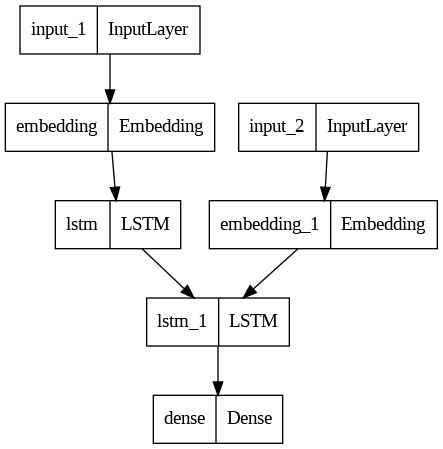

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', )

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=3)

history = model.fit(x = [encoder_input_train, decoder_input_train],
          y = decoder_target_train,
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = BATCH_SIZE,
          callbacks = [earlystopping],
          epochs = EPOCHS)

Epoch 1/100
465/465 [==============================] - 34s 35ms/step - loss: 2.5117 - acc: 0.6032 - val_loss: 2.0394 - val_acc: 0.6681
Epoch 2/100
465/465 [==============================] - 8s 16ms/step - loss: 1.8867 - acc: 0.6805 - val_loss: 1.8227 - val_acc: 0.6872
Epoch 3/100
465/465 [==============================] - 6s 14ms/step - loss: 1.6830 - acc: 0.7002 - val_loss: 1.6632 - val_acc: 0.7081
Epoch 4/100
465/465 [==============================] - 7s 14ms/step - loss: 1.4918 - acc: 0.7248 - val_loss: 1.4871 - val_acc: 0.7346
Epoch 5/100
465/465 [==============================] - 6s 13ms/step - loss: 1.3282 - acc: 0.7484 - val_loss: 1.3779 - val_acc: 0.7515
Epoch 6/100
465/465 [==============================] - 7s 15ms/step - loss: 1.2025 - acc: 0.7644 - val_loss: 1.3122 - val_acc: 0.7597
Epoch 7/100
465/465 [==============================] - 6s 12ms/step - loss: 1.1022 - acc: 0.7775 - val_loss: 1.2351 - val_acc: 0.7722
Epoch 8/100
465/465 [==============================] - 6s 14m

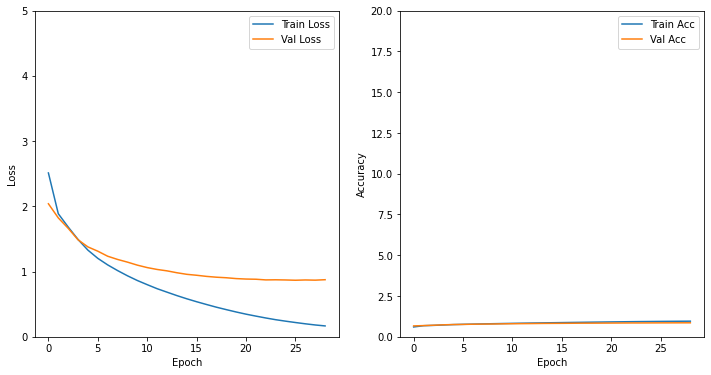

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(12, 6))

  plt.subplot(1,2,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Loss')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Loss')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['acc'],
           label='Train Acc')
  plt.plot(hist['epoch'], hist['val_acc'],
           label = 'Val Acc')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

## Inference

- 학습된 모델을 바탕으로 번역기를 만들어봅시다. -> 즉 inference용 번역기

- *교사 강요(teacher forcing)*를 사용하기 못하는 것을 제외하고는 훈련 루프와 비슷합니다. 각 마지막 시점(time step)에서 이전 디코더 인코더의 결과와 은닉 상태(hidden state)를 가진 예측 값을 디코더에 입력합니다.

    1. 번역하고자 하는 입력 문장이 인코더로 입력되어 인코더의 마지막 시점의 은닉 상태와 셀 상태를 얻습니다.
    2. 인코더의 은닉 상태와 셀 상태, 그리고 토큰 <sos>를 디코더로 보냅니다.
    3. 디코더가 토큰 <eos>가 나올 때까지 다음 단어를 예측하는 행동을 반복합니다.

In [ ]:
# 인코더 - 훈련과 동일
encoder_model = Model(encoder_inputs, encoder_states)

In [ ]:
encoder_input_train[0:1]

In [ ]:
# 인코더 모델 확인
ht, ct = encoder_model(encoder_input_train[0:1])
ht.shape, ct.shape

In [ ]:
# 디코더 (Predict)
# 학습할 때는 인코더에서 hidden, cell이 자동으로 넘어갔으나 모델을 따로 사용해야 하기 때문에 사람이 직접 넘겨줘야 한다
# Input Tensors : 이전 시점의 상태를 보관할 텐서
decoder_input_h = Input(shape=(HIDDEN_DIM,)) # input hidden state가 들어갈 공간 생성
decoder_input_c = Input(shape=(HIDDEN_DIM,)) # input cell state가 들어갈 공간 생성

decoder_states_inputs = [decoder_input_h, decoder_input_c] # [ h, c] : h, c는 노드

# 훈련 때 사용했던 임베딩 층을 재사용
x = dec_emb_layer(decoder_inputs) # input node는 더미라서 아무거나 넣어도 되지만, layer는 반드시 재사용 해야 한

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
x, state_h2, state_c2 = decoder_lstm(x, initial_state=decoder_states_inputs)
# initial_state=decoder_states_inputs :for 문 사용을 위해 직접 값을 넘겨줘야 함
# for 문은 <sos> 가 들어갔을 때 <eos>가 나올때까지 학습 위함

decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측 (Fully Connected)
x = decoder_dense(x)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs, # 리스트랑 리스트랑 더해준 것 , input 들어간 후 나오는 out put을 저장하기 위함 ([i] > [i, am] ,... 이런식으로 )
    [x] + decoder_states2) # 임베딩 층에 output 시점 층 데이터 더해줌

In [ ]:
# # 디코더 확인
# temp_h = np.random.rand(1, 256) # 돌리기 전이라 임의로 줌
# temp_c = np.random.rand(1, 256) # 돌리기 전이라 임의로 줌

In [ ]:
# x, h, c = decoder_model([decoder_input_train[0:1], temp_h, temp_c])

In [ ]:
# x.shape

In [ ]:
# h.shape

In [ ]:
# c.shape

In [62]:
# A = ['a', 'b'] #리스트 더하면 출력값과 같음
# A + ['b']

['a', 'b', 'b']

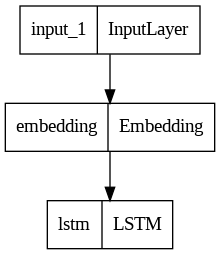

In [ ]:
# 인코더 모델 시각화
tf.keras.utils.plot_model(encoder_model)

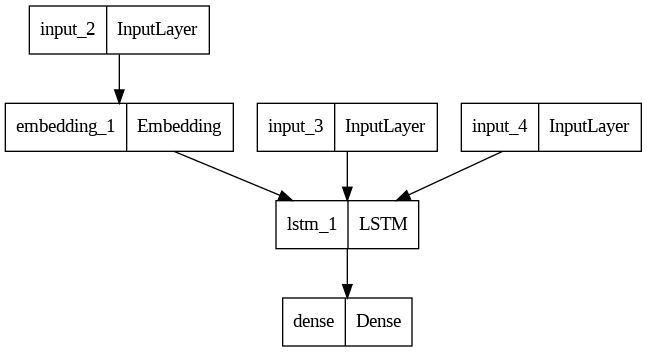

In [ ]:
# 디코더 모델 시각화
tf.keras.utils.plot_model(decoder_model)

테스트 단계에서의 동작을 위한 decode_sequence 함수를 구현합니다.
1. 입력 문장이 들어오면 인코더는 마지막 시점까지 전개하여 마지막 시점의 은닉 상태와 셀 상태를 리턴합니다. -> `states_value`
2. 디코더의 초기 입력으로 <SOS>를 준비합니다. -> `target_seq`
3. 이 두 가지 입력을 가지고 while문 안으로 진입하여 이 두 가지를 디코더의 입력으로 사용합니다.
4. 이제 디코더는 현재 시점에 대해서 예측합니다.
    - 예측 벡터로부터 현재 시점의 예측 단어인 target_seq를 얻고, h와 c 이 두 개의 값은 states_value에 저장합니다.
    - while문의 다음 루프. 즉, 두번째 시점의 디코더의 입력으로 다시 target_seq와 states_value를 사용합니다.
    - 이를 현재 시점의 예측 단어로 <eos>를 예측하거나 번역 문장의 길이가 50이 넘는 순간까지 반복합니다.
5. 각 시점마다 번역된 단어는 decoded_sentence에 누적하여 저장하였다가 최종 번역 시퀀스로 리턴합니다.

In [ ]:
# # 강사님 코드 확인

# sentence = 'Je lui ai prêté un CD.'

# sentence = preprocess_sentence(sentence) # 전처리
# tokens = sentence.split(" ") # 토큰화

# # 입력 문장 토큰 -> 라벨링
# enc_input = tokenizer_enc.texts_to_sequences([tokens])

# # 입력 문장 라벨링 -> 패딩 # 디코더는 앞에가 0이면 꼬여서 뒤에 0을 준다(인코더는 상관 없음)
# enc_input = tf.keras.preprocessing.sequence.pad_sequences(enc_input, maxlen=MAX_ENC_LEN, padding='post')
# states_value = encoder_model.predict(enc_input)

# # Decoder input인 <SOS>에 해당하는 정수 생성
# target_seq = np.zeros((1,1))
# target_seq[0, 0] = tar2idx['<sos>']


# # prediction 시작
#     # stop_condition이 True가 될 때까지 루프 반복
#     # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
# stop_condition = False
# decoded_sentence = ''

# for t in range(MAX_DEC_LEN):

#     # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
#     output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose = 0)
        # target_seq: 정수 상태로 넣어짐

#     # 예측 결과를 단어로 변환
#     result_token_index = np.argmax(output_tokens[0, -1, :]) # np.argmax: 해당 arr에서 최대값 인덱스 출력 >> 예측한 확률값 인덱스
#     result_word = idx2tar[result_token_index] # 단어 확인

#     # 현재 시점의 예측 단어를 예측 문장에 추가
#     decoded_sentence += ' '+result_word

#     # 현재 시점의 예측 결과 -> 다음 시점의 입력으로 업데이트
#     target_seq = np.zeros((1,1))
#     target_seq[0, 0] = result_token_index

#     # 현재 시점의 상태 ->  다음 시점의 상태로 업데이트
#     states_value = [h, c]

#     #  Stop condition <eos>에 도달하면 중단.
#     if result_word == '<eos>':
#         break

# print(decoded_sentence.strip(' <eos>'))

In [ ]:
# # 잘라서 보면
# sentence = 'Je lui ai prêté un CD.'

# sentence = preprocess_sentence(sentence)
# tokens = sentence.split(" ")
# print('token :', tokens)

token : ['je', 'lui', 'ai', 'prete', 'un', 'cd', '.']


In [ ]:
# # 입력 문장 토큰 -> 라벨링
# enc_input = tokenizer_enc.texts_to_sequences([tokens])
# print('enc_input: ', enc_input)
# # 입력 문장 라벨링 -> 패딩
# enc_input = tf.keras.preprocessing.sequence.pad_sequences(enc_input, maxlen=MAX_ENC_LEN, padding='post')
# print('enc_input: ', enc_input)

enc_input:  [[2, 97, 12, 327, 22, 2132, 1]]
enc_input:  [[   2   97   12  327   22 2132    1    0    0    0    0    0    0    0
     0]]


In [ ]:
# states_value = encoder_model.predict(enc_input)

1/1 [==============================] - 0s 33ms/step


In [ ]:
# states_value[0].shape, states_value[1].shape

((1, 256), (1, 256))

In [ ]:
# # Decoder input인 <SOS>에 해당하는 정수 생성
# target_seq = np.zeros((1,1))
# target_seq[0, 0] = tar2idx['<sos>']


# # prediction 시작
#     # stop_condition이 True가 될 때까지 루프 반복
#     # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
# stop_condition = False
# decoded_sentence = ''

# for t in range(MAX_DEC_LEN):

#     # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
#     output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose = 0)

#     # 예측 결과를 단어로 변환
#     result_token_index = np.argmax(output_tokens[0, -1, :])
#     result_word = idx2tar[result_token_index]

#     # 현재 시점의 예측 단어를 예측 문장에 추가
#     decoded_sentence += ' '+result_word

#     # 현재 시점의 예측 결과 -> 다음 시점의 입력으로 업데이트
#     target_seq = np.zeros((1,1))
#     target_seq[0, 0] = result_token_index

#     # 현재 시점의 상태 ->  다음 시점의 상태로 업데이트
#     states_value = [h, c]

#     #  Stop condition <eos>에 도달하면 중단.
#     if result_word == '<eos>':
#         break

# print(decoded_sentence.strip(' <eos>'))

In [ ]:
def translate(sentence):
    sentence = preprocess_sentence(sentence)
    tokens = sentence.split(" ")

    # 입력 문장 토큰 -> 라벨링
    enc_input = tokenizer_enc.texts_to_sequences([tokens])

    # 입력 문장 라벨링 -> 패딩
    enc_input = tf.keras.preprocessing.sequence.pad_sequences(enc_input, maxlen=MAX_ENC_LEN, padding='post')
    states_value = encoder_model.predict(enc_input)

    # Decoder input인 <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar2idx['<sos>']


    # prediction 시작
        # stop_condition이 True가 될 때까지 루프 반복
        # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    stop_condition = False
    decoded_sentence = ''

    for t in range(MAX_DEC_LEN):

        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose = 0)

        # 예측 결과를 단어로 변환
        result_token_index = np.argmax(output_tokens[0, -1, :])
        result_word = idx2tar[result_token_index]

        # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+result_word

        # 현재 시점의 예측 결과 -> 다음 시점의 입력으로 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = result_token_index

        # 현재 시점의 상태 ->  다음 시점의 상태로 업데이트
        states_value = [h, c]

        #  Stop condition <eos>에 도달하면 중단.
        if result_word == '<eos>':
            break

    return decoded_sentence.strip(' <eos>')

## 결과 확인

결과 확인을 위한 함수를 만듭니다.

In [ ]:
train_idx = indices[:-n_of_val]
test_idx = indices[-n_of_val:]

In [ ]:
n_samples = 5
np.random.choice(train_idx, n_samples)

array([28030, 11348,  3297, 16782, 25958])

In [ ]:
# train data - translate
n_samples = 5
for idx in np.random.choice(train_idx, n_samples):
    test_sentence = fra_corpus[idx]
    answer_sentence = eng_corpus[idx]
    decoded_sentence = translate(test_sentence)

    print("입력문장 :", test_sentence)
    print("정답문장 :", answer_sentence)
    print("번역문장 :", decoded_sentence)
    print("-"*50)

1/1 [==============================] - 0s 418ms/step
입력문장 : Je lui ai prêté un CD.
정답문장 : I lent him a CD.
번역문장 : i lent him a cd .
--------------------------------------------------
1/1 [==============================] - 0s 20ms/step
입력문장 : Où est mon téléphone ?
정답문장 : Where's my phone?
번역문장 : where s my ticket ?
--------------------------------------------------
1/1 [==============================] - 0s 18ms/step
입력문장 : Ce n'est pas que ça.
정답문장 : It's not just that.
번역문장 : it s not that .
--------------------------------------------------
1/1 [==============================] - 0s 18ms/step
입력문장 : Restons calmes.
정답문장 : Let's keep quiet.
번역문장 : let s keep quiet .
--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
입력문장 : Pouvez-vous le prouver ?
정답문장 : Can you prove that?
번역문장 : can you prove it ?
--------------------------------------------------


In [ ]:
# test data - translate
n_samples = 5
for idx in np.random.choice(test_idx, n_samples):
    test_sentence = fra_corpus[idx]
    answer_sentence = eng_corpus[idx]
    decoded_sentence = translate(test_sentence)

    print("입력문장 :", test_sentence)
    print("정답문장 :", answer_sentence)
    print("번역문장 :", decoded_sentence)
    print("-"*50)

1/1 [==============================] - 0s 31ms/step
입력문장 : Je suis confus.
정답문장 : I am baffled.
번역문장 : i m confused .
--------------------------------------------------
1/1 [==============================] - 0s 28ms/step
입력문장 : Je ne suis pas en train de mentir.
정답문장 : I'm not lying.
번역문장 : i m not going .
--------------------------------------------------
1/1 [==============================] - 0s 27ms/step
입력문장 : Il travaille très dur.
정답문장 : He works very hard.
번역문장 : he works very fast .
--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
입력문장 : Tu es endurante.
정답문장 : You're resilient.
번역문장 : you re resilient .
--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
입력문장 : Nous avons choisi celui-ci.
정답문장 : We chose this one.
번역문장 : we have a deal .
--------------------------------------------------


## BLEU Score (Bilingual Evaluation Understudy Score)
기계 번역의 성능이 얼마나 뛰어난가를 측정하기 위해 사용되는 대표적인 방법 중 하나인 BLEU(Bilingual Evaluation Understudy)를 측정해봅시다.
- 논문 : BLEU: a Method for Automatic Evaluation of Machine Translation
- BLEU 점수는 기계 번역된 텍스트와 고품질 참조 번역 세트의 유사성을 측정하는 0과 1 사이의 숫자입니다.
    - 값이 0이면 기계 번역된 출력이 참조 번역과 겹치는 부분이 없는 것을 의미하고(저품질)
    - 1이면 참조 번역과 완벽하게 겹치는 것을 의미합니다(고품질)

- BLEU 설명
    - https://jrc-park.tistory.com/273
    - https://wikidocs.net/31695
    - https://cloud.google.com/translate/automl/docs/evaluate?hl=ko#bleu

BLEU는 기계 번역 결과와 사람이 직접 번역한 결과가 얼마나 유사한지 비교하여 번역에 대한 성능을 측정하는 방법입니다.

In [ ]:
!pip install evaluate

In [ ]:
import evaluate
predictions = ["hello there general kenobi", "foo bar foobar"]
references = [
    ["hello there general kenobi", "hello there !"],
    ["foo bar foobar"]
 ]

bleu = evaluate.load("bleu")

results = bleu.compute(predictions=predictions, references=references)

print(results)

{'bleu': 1.0, 'precisions': [1.0, 1.0, 1.0, 1.0], 'brevity_penalty': 1.0, 'length_ratio': 1.1666666666666667, 'translation_length': 7, 'reference_length': 6}


In [ ]:
from tqdm.notebook import tqdm

n_samples = 10
ref_train, pred_train = [], []
for idx in tqdm(np.random.choice(test_idx, n_samples)):
    ref_train.append(eng_corpus[idx])
    pred_train.append(translate(fra_corpus[idx]))


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


In [ ]:
print(ref_train)
print(pred_train)

["I didn't register.", 'Can we talk?', "I'm proud of that.", "Let's kiss.", "It's unlocked.", "I'm in charge here.", 'Can you show me?', "It'll work.", "That's true.", 'I was born in 1972.']
['i didn t stop .', 'can we go ?', 'i m proud of that .', 'let s move .', 'it s easily done .', 'i m the boss .', 'do animals eat fish ?', 'it ll work .', 'this is correct .', 'i m not here .']


In [ ]:
bleu.compute(predictions=pred_train, references=ref_train)

{'bleu': 0.11073049583498255,
 'precisions': [0.3191489361702128,
  0.10810810810810811,
  0.07407407407407407,
  0.058823529411764705],
 'brevity_penalty': 1.0,
 'length_ratio': 1.146341463414634,
 'translation_length': 47,
 'reference_length': 41}

### Reference

- https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
- https://wikidocs.net/86900